# Initial data processing and analysis of TMT labeled proteome data 
## searched with MaxQuant v.1.6.10.43 with unitprot reviewed mouse DB, without isoforms, with PIF cutoff (0.75) and iBAQ calculation enabled

### Author: Konstantin Kahnert
### Date: 2020_09_09

After creating the QC report we continue with the exploratory data analysis.  
In this script we will:

- remove unreliably quantified proteins
- impute remaining missing values
- normalize TMT channels
- hierachical clustering
- PCA

## Load required packages

In [3]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from Quantile_Normalize.quantile_norm import quantileNormalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text
from sklearn.impute import KNNImputer

## Define required functions

In [52]:
def filter_missing_value_by_group(df, identifiers, cutoff=2):
    """
    Removes rows of df where more than cutoff percent of the values are missing in a sample group

    Note: Common identifier must be included in column name

    df: pandas dataframe with sample names as columns and proteins as rows
    identifiers: list of common identifiers for each sample group
    cutoff: number of missing values allowed per group

    returns: filtered data frame
    """
    # copy df
    df_filtered = df.copy()

    # iterate through rows of df (proteins)
    for idx, row in df.iterrows():

        # set remove flag to False
        remove = False

        # iterate through list of identifiers
        for group in identifiers:

            # filter row by sample group
            row_filtered = row.filter(regex=group)

            # count number of missing values
            missing_values = row_filtered.isna().sum()

            # if there is more than one missing value, set remove to True
            if missing_values >= cutoff:
                remove = True

        # if remove is True (more than one missing value in one group), remove row from df
        if remove is True:
            df_filtered.drop(idx, axis=0, inplace=True)

    return df_filtered


def impute_KNN(df, neighbors=5, num_samples=10):
    """
    Imputes missing values using the kNN imputation algorithm from scikit-learn for each column separately

    df: dataframe (all columns will be imputed)
    neighbors: Number of neighboring samples to use for imputation

    returns: df_imputed, imputed, fig_histograms

    df_imputed: imputed dataframe
    imputed: mask showing which values are imputed (boolean)
    histogram: figure showing the distribution of reals and imputed values
    """
    # keep track of which values are imputed
    imputed = df.isna()

    # initiate KNN imputer
    imputer = KNNImputer(n_neighbors=neighbors, weights="distance")

    # impute missing values
    df_imputed = imputer.fit_transform(df)

    # transpose back again (see above transposing)
    df_imputed = df_imputed.copy()

    # convert to pd dataframe again
    df_imputed = pd.DataFrame(data=df_imputed, columns=df.columns, index=df.index)

    # extract imputed and real values
    df_real_values = df_imputed[~imputed]
    df_imputed_only = df_imputed[imputed]

    # # plot histograms of real and imputed values
    # set background style for the plots
    sns.set_style("white")

    # calculate how many subplots are needed for the amount of samples given (setting 4 columns as fixed)
    num_rows = math.ceil(len(df_imputed.columns)/4)

    # create figure with subplots (layout depends on number of samples)
    fig_histograms, ax = plt.subplots(num_rows, 4, figsize=(10, 6))

    # fill up all the subplots
    for i in range(num_rows * 4):
        # activate next subplot
        row = int(i / 4)
        col = i % 4
        plt.sca(ax[row, col])

        # fill up the first num_samples subplots
        if i < num_samples:
            # calculate bin edges
            bin_edges = list(np.histogram(a=df_imputed, bins=20)[1])

            # plot histogram of real values
            sns.distplot(df_real_values.iloc[:, i], kde=False, bins=bin_edges, color="#1f77b4",
                         hist_kws=dict(alpha=0.9))

            # plot histogram of imputed values
            sns.distplot(df_imputed_only.iloc[:, i], kde=False, bins=bin_edges, color="#e74c3c",
                         hist_kws=dict(alpha=0.9), ax=ax[row, col])

            # add title
            plt.title(df_real_values.columns[i])

            # set axis limit
            plt.xlim(2.5, 27.5)
            plt.ylim(0, 1100)

            # remove all ticks and labels
            # plt.yticks([], [])
            # plt.xticks([], [])
            plt.ylabel("")
            plt.xlabel("")

        elif i == num_samples:
            legend_elements = [Patch(facecolor="#1f77b4", alpha=0.9, label="Real Values"),
                               Patch(facecolor="#e74c3c", alpha=0.9, label="Imputed Values")]
            ax[row, col].legend(handles=legend_elements, loc="center")

            # remove all ticks and labels
            ax[row, col].axis('off')

        # remove empty subplots
        else:
            plt.axis('off')

    # add title to plot
    plt.suptitle("Distribution of real (blue) and imputed (red) values per sample", weight="bold", y=1.05)

    # make plot look nice
    plt.tight_layout()

    return df_imputed, imputed, fig_histograms


def normalize_prot_int(df, method):
    """
    Normalizes the protein intensities sample wise (coulumns) by using the specified method

    df: pandas dataframe, columns=samples, rows=proteins
    method: quantile, Z or median subtraction

    returns: normalized dataframe
    """
    # choose method
    if method == "quantile":
        df_norm = quantileNormalize(df)
    elif method == "Z":
        scaler = StandardScaler()
        df_norm = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    elif method == "median subtraction":
        median_val = df.median(axis=0)
        df_norm = df.apply(lambda x: x - median_val, axis=1)
    else:
        raise ValueError(
            "Unknown normalization method specified. Choose either \"quantile\", \"Z\" or \"median subtraction\"")

    return df_norm


def plot_density_curves(df, title="Intensity distribution"):
    """
    Takes a data frame and plots the density curve of each column into one plot

    input: pandas dataframe (all columns are plotted)
    title: str, title of the plot

    returns: figure
    """
    # set plot style to white background
    sns.set_style("white")

    # create new figure
    fig = plt.figure(figsize=(8, 6))

    # iterate through all samples
    for sample in df.columns:

        # extract column of given sample
        df_sample = df[sample]

        # draw density curve
        sns.distplot(df_sample, hist=False, kde=True, kde_kws={'linewidth': 2}, label=sample)

    # Plot formatting
    plt.legend(prop={'size': 10, "weight": "bold"}, title='Sample')
    plt.title(title, fontsize=15, weight="bold")
    plt.xlabel('log2(Intensity)', weight="bold", fontsize=15)
    plt.ylabel('Density', weight="bold", fontsize=15)
    plt.gca().tick_params(axis='both', which='major', labelsize=15)

    return fig


def plot_clustermap(df, title="Hierarchical Clustering"):
    """
    Takes data frame, applies hierarchical clustering to columns and plots the resulting clustermap with dendrogram

    input: pandas dataframe (all columns are plotted)
    title= str, title of the plot

    :return: figure
    """

    # plot clustermap
    fig = sns.clustermap(df, metric="correlation", cmap="bwr", z_score=0, dendrogram_ratio=(0.4, 0.2), figsize=(8, 10))

    # remove y axis labels (protein names)
    plt.sca(fig.fig.axes[2])
    plt.yticks([])
    plt.ylabel("")

    # rotate x tick labels
    plt.xticks(rotation=45)

    # set title
    fig.ax_col_dendrogram.set_title(title, weight="bold")

    return fig


def calculate_principal_components(df, nr_components=2):
    """
    Takes a data frame, performs a principle component analysis on the columns
    and returns PCs, explained variance and feature importance
    """
    # Separating out the features
    x = df.T

    # Separating out the target
    y = x.index.values

    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    # initiate PCA model
    pca = PCA(n_components=nr_components)

    # calculate principal components
    principal_components = pca.fit_transform(x)

    # generate column names
    cols = []
    for i in range(nr_components):
        cols.append("Principal Component " + str(i+1))

    # convert principal components to data frame
    df_principal_components = pd.DataFrame(data=principal_components, columns=cols)

    # add protein names as index to principalDf
    df_principal_components.set_index(y, inplace=True)

    # get variance explained by components
    variance_explained = pca.explained_variance_ratio_

    # get feature importance
    df_feature_importance = pd.DataFrame(data=pca.components_, columns=df.index).T

    # sort features by descending PC1 values
    df_feature_importance.sort_values(by=0, inplace=True, ascending=False)

    return df_principal_components, variance_explained, df_feature_importance


def plot_principal_components(df, variance_explained, identifier=None, title="2 Component PCA", hue=True, annotate=True):
    """
    Takes a data frame of PCs and plots the top two principal components against each other
    """
    if hue is True:
        # add new group column
        # create empty list to fill up with names
        group = pd.Series(np.ones(len(df.index.values)), index=df.index.values)

        # create a group series to use for coloring according to experimental group
        group_num = 0
        for elm in identifier:
            for sample in df.index.values:
                if len(re.findall(elm, sample)) != 0:
                    group[sample] = "Group " + str(group_num)
                else:
                    pass
            group_num += 1

        # create new figure
        fig = plt.figure()

        # use specific (colorblind safe) colors in case of two groups
        if len(set(group)) == 2:
            # set colors
            colors = sns.color_palette(["blue", "red"])

            # other colors
            # "#ff1284", "#f67089"
            # "#f565cc"

            # plot PCs as scatter plot
            sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue=group,
                            palette=colors, data=df, s=300)

        else:
            # plot PCs as scatter plot
            sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue=group,
                            palette="husl", data=df, s=300)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.xlim(-85, 85) 
        plt.ylim(-80, 80)
        
    else:
        # create new figure
        fig = plt.figure()

        # plot PCs as scatter plot
        sns.scatterplot(x="Principal Component 1", y="Principal Component 2", data=df, s=300,
                        palette="husl", legend=False)

    # add title
    plt.title(title, weight="bold", fontsize=15)

    # add axis labels
    plt.xlabel(df.columns[0] + " (" + str(int(round(variance_explained[0] * 100, 0))) + "%)", fontsize=15, weight="bold")
    plt.ylabel(df.columns[1] + " (" + str(int(round(variance_explained[1] * 100, 0))) + "%)", fontsize=15, weight="bold")

    # change size of tick labels
    plt.gca().tick_params(axis='both', which='major', labelsize=15, direction="out", color="black", length=5, width=1.5)
    plt.gca().tick_params(axis='y', which='major', labelsize=15, direction="out", color="black", length=4.5, width=1.5)

    # add annotations one by one with a loop
    if annotate is True:
        texts = []
        for line in range(len(df)):
            texts.append(plt.text(df["Principal Component 1"][line] + 0.2, df["Principal Component 2"][line],
                         df.index[line], horizontalalignment='left', size='medium', color='black'))

        # adjust text to avoid overlapping with arrows
        # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

        # adjust text to avoid overlapping with arrows
        adjust_text(texts, expand_points=(1.5, 1.5))

    else:
        pass

    return fig


def save_figure(fig, name):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None

##  Specify location of the proteinGroups_log.csv file (output of the 01_data_QC script) and use it to generate the path of the outputfolder

In [5]:
# specify location of the proteinGroups_log.csv output file from script 01_data_QC
path_proteingroups_log = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Proteome\Analysis\canonical\w_PIF\02_initial_analysis\proteinGroups_log.csv"

# set path for output
folder_output = "".join(re.findall("[^\\\\]+\\\\", path_proteingroups_log))

## Specify the type of normalization method that should be used
Can be one one of the following: "median subtraction", "quantile", "Z"

In [6]:
# set normalization method
norm_method = "median subtraction"

## Specify identifiers of experimental groups (must be contained in sample name (can be regex)

In [7]:
# set identifiers
group_identifier = ["Sham", "TAC"]

## Load the log transformed data

In [8]:
# load file to pandas data frame
df_proteingroups_log = pd.read_csv(path_proteingroups_log, index_col=0)

# check if it ewas loaded correctly
print()
df_proteingroups_log.head(5)

,Sham 1,Sham 2,Sham 3,Sham 4,Sham 5,TAC 1,TAC 2,TAC 3,TAC 4,TAC 5,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
0,16.235229,15.726112,16.120015,16.150461,15.660358,16.412636,16.681815,16.082606,15.711855,16.249539,...,NaN,0,6069;8344;8870;13813;19817;31684;39687,True;True;True;True;True;True;True,6333;8706;9250;9251;14422;20662;33317;41657,17467;17468;24091;25559;25560;25561;25562;2556...,11890;16386;17364;17365;17366;17367;17368;2768...,11890;16386;17367;27682;38853;60572;75514,0,352
1,12.169267,11.656201,11.731149,12.046067,11.415161,14.009829,13.404609,12.722701,12.493455,13.663892,...,NaN,2,8075,True,8429,23393,15915,15915,NaN,NaN
2,16.341449,15.874141,16.494606,16.917186,15.918025,17.268743,17.501448,16.156774,16.589388,17.210766,...,NaN,3,6875;9957;9997;19846;21301;24900;30715;32041;3...,True;True;True;True;False;True;True;False;Fals...,7170;10392;10433;20691;22201;25922;32320;33686...,20019;20020;28865;28866;29007;56623;60447;6044...,13630;13631;19648;19649;19743;38911;41620;4162...,13630;19649;19743;38911;41621;48121;59030;6127...,NaN,NaN
3,17.121412,16.715050,16.876517,17.421276,16.466777,17.763251,17.736217,17.179326,17.118373,17.975837,...,NaN,6,1341;5441;7396;8665;18925;19306;20141;20260;24...,True;True;True;True;True;True;True;True;True;T...,1410;5671;7705;9037;19738;20132;20991;21113;25...,4183;15524;21501;24914;54064;55057;57365;57366...,2828;10467;14620;16921;37137;37807;39463;39709...,2828;10467;14620;16921;37137;37807;39463;39709...,2,1
4,8.834597,9.516606,10.400239,9.944068,9.145983,10.599076,10.422065,10.017087,10.072803,10.773799,...,NaN,7,23613,True,24599,66471,45851,45851,NaN,NaN


## Remove proteins (rows) with more than a specified number of missing values per experimental group

In [9]:
# remove proteins with more than 2 (out of 5) missing values per experimental group
df_proteingroups_log_filtered = filter_missing_value_by_group(df_proteingroups_log, group_identifier, cutoff=2)

# check how many proteins were removed
print("Number of proteins removed:")
print(len(df_proteingroups_log) - len(df_proteingroups_log_filtered))

Number of proteins removed:
19


## Extract log intensity columns

In [10]:
df_proteingroups_log_filtered_int = df_proteingroups_log_filtered.set_index("Majority protein IDs").filter(regex="(Sham)|(TAC)")
df_proteingroups_log_filtered_int

,Sham 1,Sham 2,Sham 3,Sham 4,Sham 5,TAC 1,TAC 2,TAC 3,TAC 4,TAC 5
Majority protein IDs,,,,,,,,,,
P0DPB4;A0A088MLT8,16.235229,15.726112,16.120015,16.150461,15.660358,16.412636,16.681815,16.082606,15.711855,16.249539
A1L314,12.169267,11.656201,11.731149,12.046067,11.415161,14.009829,13.404609,12.722701,12.493455,13.663892
A2A432,16.341449,15.874141,16.494606,16.917186,15.918025,17.268743,17.501448,16.156774,16.589388,17.210766
A2A5R2,17.121412,16.715050,16.876517,17.421276,16.466777,17.763251,17.736217,17.179326,17.118373,17.975837
A2A690,8.834597,9.516606,10.400239,9.944068,9.145983,10.599076,10.422065,10.017087,10.072803,10.773799
...,...,...,...,...,...,...,...,...,...,...
Q9Z315,17.112684,16.717328,16.760070,17.167222,16.536141,17.728067,17.620206,17.431024,16.970623,17.878913
Q9Z319,17.249706,17.091146,17.303406,17.675213,16.644560,17.104722,17.211052,17.380004,17.068757,16.991920
Q9Z321,15.837751,15.459720,15.718506,15.881257,15.151017,16.364100,16.150144,16.043882,15.466554,16.611227


## Impute the remaining missing values using kNN imputation

Number of imputed values per sample
Sham 1    0
Sham 2    6
Sham 3    3
Sham 4    1
Sham 5    4
TAC 1     0
TAC 2     2
TAC 3     1
TAC 4     6
TAC 5     0
dtype: int64


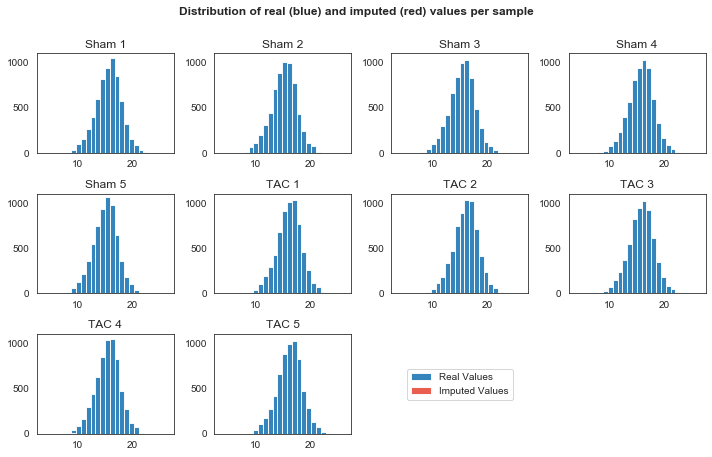

In [11]:
# impute remaining missing values by kNN imputation
df_proteingroups_log_imputed, imputed, fig_imputed = impute_KNN(df_proteingroups_log_filtered_int, neighbors=3)

# show number of imputed values per sample
print("Number of imputed values per sample")
print(imputed.sum())

# save figure
save_figure(fig_imputed, "imputation_histograms")

# # add remaing columns back to the dataframe
df_proteingroups_log_imputed_save = df_proteingroups_log_imputed.reset_index(drop=True)
df_proteingroups_log_filtered_save = df_proteingroups_log_filtered.reset_index(drop=True)

df_proteinGroups_log_imputed_combined = pd.concat([df_proteingroups_log_imputed_save, df_proteingroups_log_filtered_save.iloc[:,10:]], axis=1)

# save imputed dataframe
# create new path name for saving dataframe as csv
path_out = folder_output + "\\df_proteingroups_log_imputed.csv"

# write to file
df_proteinGroups_log_imputed_combined.to_csv(path_out, index=False)

## Normalize protein intensities per TMT channel to account for differences in total protein loading between channels

In [12]:
# normalize protein intensities 
df_proteingroups_log_norm = normalize_prot_int(df_proteingroups_log_imputed, method=norm_method)

# # add remaing columns back to the dataframe
# check of the order of proteins is still the same
print(sum(df_proteingroups_log_norm.index != df_proteingroups_log_filtered["Majority protein IDs"]))

# combine dataframe
df_proteingroups_log_norm.reset_index(drop=True, inplace=True)
df_proteingroups_log_filtered.reset_index(drop=True, inplace=True)

df_proteinGroups_log_norm_combined = pd.concat([df_proteingroups_log_norm, df_proteingroups_log_filtered.iloc[:,10:]], axis=1)

# create new path name for saving dataframe as csv
path_out = folder_output + "\\df_proteingroups_log_" + norm_method + "_norm.csv"

# write to file
df_proteinGroups_log_norm_combined.to_csv(path_out, index=False)

0


## Plot density curves of raw and normalized intensities

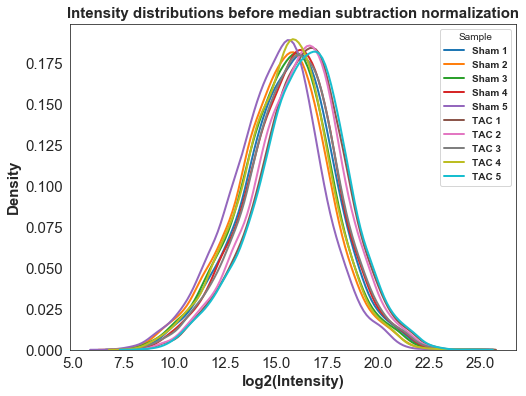

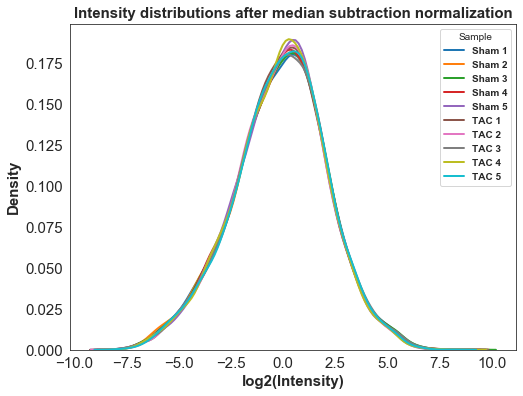

In [13]:
# plot density curves before normalization 
fig_density_before = plot_density_curves(df_proteingroups_log_filtered_int,
                                         title="Intensity distributions before " + norm_method + " normalization")

# save figure
save_figure(fig_density_before, "density_before_norm")

# plot density curves after normalization 
fig_density_after = plot_density_curves(df_proteingroups_log_norm,
                                        title="Intensity distributions after " + norm_method + " normalization")

# save figure
save_figure(fig_density_after, "density_" + norm_method + "_norm")

## Perform hierachical clustering and draw heatmap and dendrograms

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


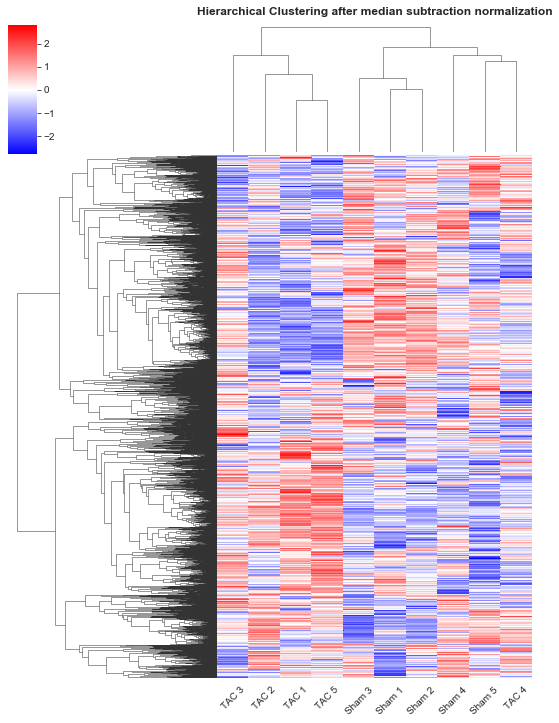

In [14]:
# perform hierachical clustering and plot clustermap with dendrogram
fig_clustermap = plot_clustermap(df_proteingroups_log_norm,
                                 title="Hierarchical Clustering after " + norm_method + " normalization")

# save figure
save_figure(fig_clustermap, "clustermap_" + norm_method + "_norm")

## Perform Pricipal Component Analysis (PCA) and visualize the first two principal components

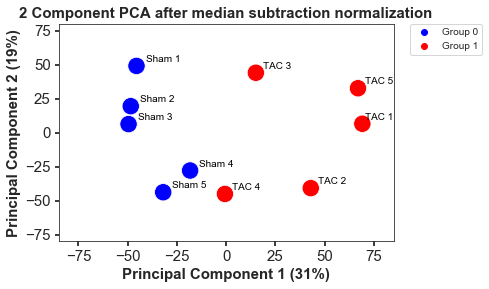

In [53]:
# calculate PCs
df_PCs, variance_explained, df_feature_importance = calculate_principal_components(df_proteingroups_log_norm,
                                                                                   nr_components=2)

# set axes style 
sns.set_style("ticks", {"xtick.major.size": 10, "ytick.major.size": 10})

# plot principal components
fig_PCA = plot_principal_components(df_PCs, variance_explained, identifier=group_identifier,
                                    title="2 Component PCA after " + norm_method + " normalization",
                                    hue=True, annotate=True)

# save figure
save_figure(fig_PCA, "PCA_plot_" + norm_method + "_norm")